__Análise de dados Docking__

Caso não tenha alguma biblioteca

In [24]:
'''
!pip install rmsd
!pip install periodictable
!pip install heatmapz
!pip install plotly
'''

'\n!pip install rmsd\n!pip install periodictable\n!pip install heatmapz\n!pip install plotly\n'

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rmsd
import periodictable as pt
from pylab import rcParams
from heatmap import heatmap, corrplot
rcParams['figure.figsize'] = 7,7 
sns.set(color_codes=True, font_scale=1.2)

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'browser'
fig=go.Figure()

%matplotlib inline  

Esse algoritmo analisa uma pasta com arquivos pdbqt gerados por docking com o vina e as transforma em um dataframe com a posição do centro de mass, valor do RMSD e energia.

Para esse notebook funcionar corretamente, você precisa instalar bibliotecas como, rmsd, periodictable, numpy e pandas.

Qualquer questão escreva para rafael.pleite@usp.br

Funções para extrair os dados dos arquivos .pdbqt

In [65]:
def load(i):
    data = ''
    with open(i) as fp:
        data = fp.read()
    data = data.split('\n')
    return data

def CalcMassAtom(Matrix):
    data = []
    for x in range(len(Matrix)):
        A = Matrix[x].split()
        if len(A) != 0 and A[0] == 'HETATM' and A[2][0] != 'H':
            data.append([A[5], A[6], A[7], A[2][0]])
    return data

def AssingMass(Pos_atom):
    for i in range(len(Pos_atom)): #Change the atom name for atom mass
        for j in range(len(Pos_atom[0])):
            Pos_atom[i][j][3] = MassAtom(Pos_atom[i][j][3])
    return Pos_atom

def PositionAtom(Data_, n_atom):
    Positions = []
    for i in range(0, len(Data_), n_atom):
        Positions.append(Data_[i:n_atom+i])
    return Positions

def MassAtom(At):
    Atom = str(At)
    if Atom == 'C':
        return float(pt.C.mass)
    elif Atom == 'O':
        return float(pt.O.mass)
    elif Atom == 'N':
        return float(pt.N.mass)
    elif Atom == 'F':
        return float(pt.F.mass)
    elif Atom == 'Cl':
        return float(pt.Cl.mass)
    else:
        return None
    
def CM(Pos_mass):
    Matrix = np.array(Pos_mass)
    PositionCM = [float(0), float(0), float(0)]
    M = 0
    for i in range(len(Matrix)):
        M += float(Matrix[i,3])
        PositionCM[0] += float(Matrix[i,0])*float(Matrix[i,3])
        PositionCM[1] += float(Matrix[i,1])*float(Matrix[i,3])
        PositionCM[2] += float(Matrix[i,2])*float(Matrix[i,3])
    return [PositionCM[0]/M, PositionCM[1]/M, PositionCM[2]/M]

def TransformFloat(M):
    P = M
    for i in range(len(P)):
        for j in range(len(P[i])):
            P[i][j] = float(P[i][j])
    return P

Essa parte é vital para o funcionamente correto do código.

Abaixo entre com o caminho da pasta com os arquivos .pdbqt e o correto número de átomos do ligante menos o número de hidrogênios.

Exemplo: Luteolin possui a seguinte fórmula C15H10O6, ou seja, são (31 átomos - 10 átomos de hidrogênios) = 21 átomos

In [66]:
Path = 'C:\SARSCOV2\OAII\LuteolinPLProPOOL\LuteolinPLpro\Teste\Resultados'
n_atom = 21

Entre aqui com o nome do arquivo de referencial, isto é, o seu melhor resultado para ser o referencial do sistema que calcula o RMSD

In [67]:
Referential_pos = r'\proteina-ligante,60,23,15,.pdbqt'

In [68]:
Referential = list(np.array(AssingMass(PositionAtom(CalcMassAtom(load(Path + Referential_pos)), n_atom)), float)[0,:,:3])
    
Principal = np.zeros((1,5))
    
if str(input('Digite [S] para analisar todos os arquivos .pdbqt do diretório ou [N] para analisar apenas o seu referencial de RMSD: ')).upper() == 'S':
    for root, directories, files in os.walk(Path, topdown=False):
        for name in files:
            if name.find('pdbqt') != -1:
                Data_load = load(str(Path + r'\b'[0]+ name))
                Data_ = CalcMassAtom(Data_load)
                    
                #Take de coordinates of atom and your name
                Pos_atom = PositionAtom(Data_, n_atom)
                Pos_atom = AssingMass(Pos_atom)
                    
                CM_pos = [] #Calculate de center of mass
                for x in Pos_atom:
                    CM_pos.append(CM(x))
                        
                Array_pos_atom = np.array(Pos_atom, float)
                RMSD = []
                for j in range(len(CM_pos)):
                    RMSD.append(rmsd.rmsd(Referential, list(Array_pos_atom[j,:,:3])))
                    
                Energy = []
                for x in range(len(Data_load)):
                    A = Data_load[x].split()
                    if len(A) >= 3 and A[1] == 'VINA':
                        Energy.append(float(A[3]))
                            
                No_principal = []
                for i in range(len(RMSD)):
                    No_principal.append([CM_pos[i][0], CM_pos[i][1], CM_pos[i][2] ,RMSD[i], Energy[i]])
                No_principal = np.array(No_principal)
                Principal = np.append(Principal, No_principal, axis=0) #add RMSD to principal
                    
else:
    for root, directories, files in os.walk(Path, topdown=False):
        for name in files:
            if name.find(Referential_pos[1:]) != -1:
                Data_load = load(str(Path + r'\b'[0]+ name))
                Data_ = CalcMassAtom(Data_load)
                
                #Take de coordinates of atom and your name
                Pos_atom = PositionAtom(Data_, n_atom)
                Pos_atom = AssingMass(Pos_atom)
                
                CM_pos = [] #Calculate de center of mass
                for x in Pos_atom:
                    CM_pos.append(CM(x))
                        
                Array_pos_atom = np.array(Pos_atom, float)
                RMSD = []
                for j in range(len(CM_pos)):
                    RMSD.append(rmsd.rmsd(Referential, list(Array_pos_atom[j,:,:3])))
                    
                Energy = []
                for x in range(len(Data_load)):
                    A = Data_load[x].split()
                    if len(A) >= 3 and A[1] == 'VINA':
                        Energy.append(float(A[3]))
                            
                No_principal = []
                for i in range(len(RMSD)):
                    No_principal.append([CM_pos[i][0], CM_pos[i][1], CM_pos[i][2] ,RMSD[i], Energy[i]])
                No_principal = np.array(No_principal)
                Principal = np.append(Principal, No_principal, axis=0) #add RMSD to principal
                
Principal = np.delete(Principal, 0, 0)
df = pd.DataFrame(Principal, columns=('x', 'y', 'z', 'RMSD', 'Energy'))

Digite [S] para analisar todos os arquivos .pdbqt do diretório ou [N] para analisar apenas o seu referencial de RMSD: S


Remove os valores de energia > 0.

In [69]:
df = df[df['Energy'] <=0]

Informações sobre o DataFrame.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3363 entries, 0 to 3362
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       3363 non-null   float64
 1   y       3363 non-null   float64
 2   z       3363 non-null   float64
 3   RMSD    3363 non-null   float64
 4   Energy  3363 non-null   float64
dtypes: float64(5)
memory usage: 157.6 KB


Melhores valores de energia.

In [81]:
df.sort_values(by=['Energy']).head(60)

,x,y,z,RMSD,Energy
1932,60.485769,23.419552,18.576984,0.000000,-8.9
1941,60.464784,23.426756,18.555649,0.040864,-8.9
1933,57.437527,23.533292,16.284492,7.519324,-8.8
1761,45.786486,47.644405,-8.122137,39.249817,-8.8
1349,45.700642,47.612452,-8.010813,39.193701,-8.7
1714,45.803475,47.742407,-8.116139,39.296846,-8.7
2094,55.823330,40.634080,28.470035,20.683037,-8.7
2049,55.785434,40.587579,28.424746,20.623017,-8.7
2058,55.825401,40.619856,28.457556,20.667280,-8.7
1574,57.138953,23.508215,16.475685,7.544488,-8.6


__Gráficos__

Gráfico da distribuição espacial dos pontos.

In [72]:
fig = px.scatter_3d(df, x = df['x'],  y = df['y'],  z = df['z'], color = df['Energy']) 
fig.show()

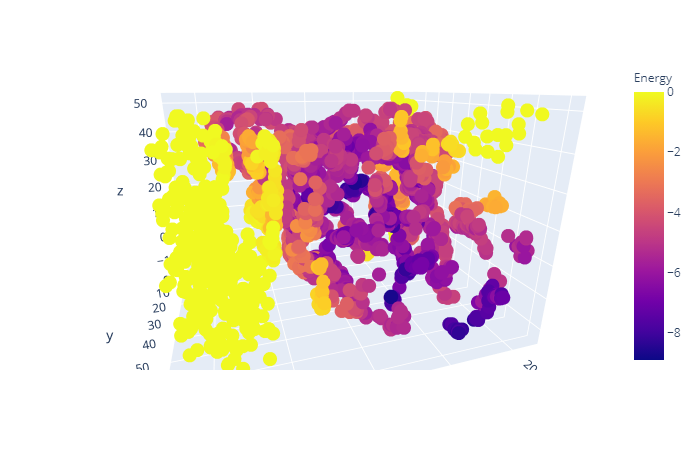

Gráfico de correlação

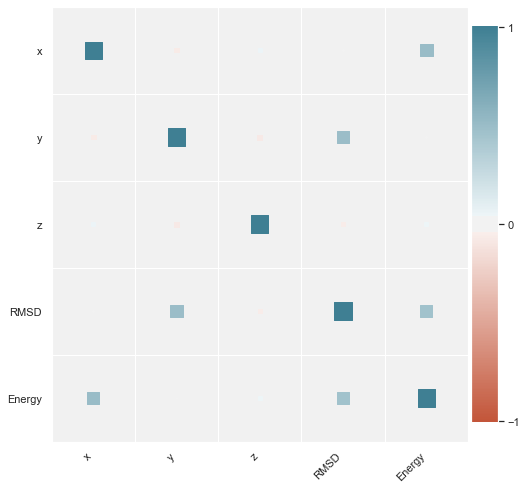

In [73]:
plt.figure(figsize=(8, 8))
corrplot(df.corr(), size_scale=300)
#plt.savefig('Correlacao'+'.png', dpi=600)

Aqui vão alguns gráficos de dispersão sem filtragem no valor da energia.

Repare que o gráfico fica muito poluido.

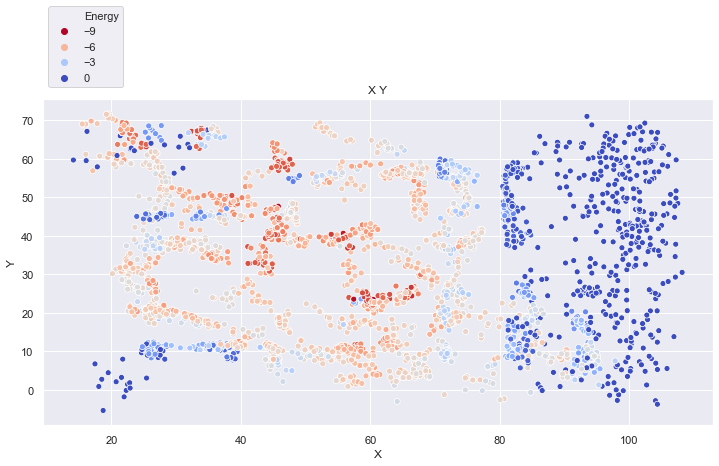

In [74]:
sns.set(color_codes=True, font_scale=1)
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='Energy',palette='coolwarm_r')
svm.set_title("X Y")
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left')
figure = svm.get_figure()    
#para salvar a figura
#figure.savefig('XY'+'.png', dpi=600)

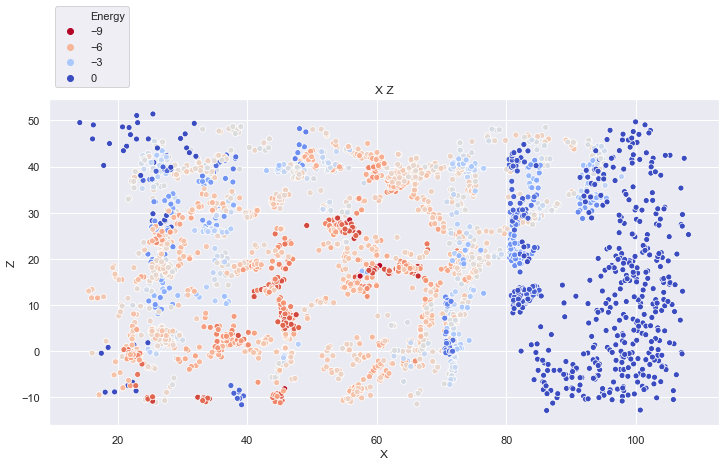

In [75]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='Energy',palette='coolwarm_r')
svm.set_title("X Z")
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left')
figure = svm.get_figure() 
#para salvar a figura
#figure.savefig('XY'+'.png', dpi=600)

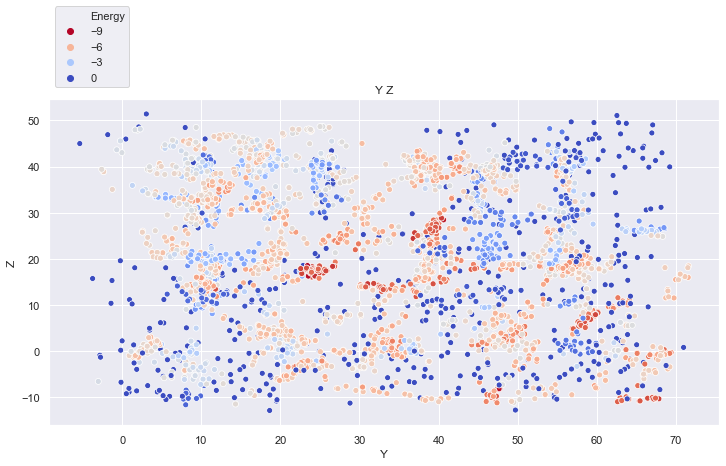

In [76]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='Energy',palette='coolwarm_r')
svm.set_title("Y Z")
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left')
figure = svm.get_figure() 
#para salvar a figura
#figure.savefig('XY'+'.png', dpi=600)

Filtro valores de energia <= -6 para uma melhor vizualização dos resultados

In [77]:
df = df[df['Energy'] <=-8]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 702 to 2409
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       103 non-null    float64
 1   y       103 non-null    float64
 2   z       103 non-null    float64
 3   RMSD    103 non-null    float64
 4   Energy  103 non-null    float64
dtypes: float64(5)
memory usage: 4.8 KB


Gráfico da distribuição espacial dos pontos

In [78]:
fig = px.scatter_3d(df, x = df['x'],  y = df['y'],  z = df['z'], color = df['Energy']) 
fig.show()

In [82]:
df

,x,y,z,RMSD,Energy
702,25.386242,63.064674,-10.804331,60.719938,-8.3
1080,25.386474,63.067848,-10.807708,60.723649,-8.3
1081,34.048380,67.357015,-10.331365,58.952702,-8.2
1082,32.363825,67.103700,-9.956807,59.603607,-8.2
1083,33.279653,62.995537,-10.723625,56.276573,-8.1
...,...,...,...,...,...
2310,66.398546,24.364657,16.293195,8.827128,-8.5
2311,66.409252,26.604204,18.383009,9.530424,-8.4
2312,65.638120,25.753448,17.416087,8.892402,-8.2
2313,64.675962,24.941315,18.488589,7.416977,-8.0


É prático também vizualizarmos um gráfico da distribuição espacial dos pontos em uma dada região, ou seja, para um intervalo
x, y, z. (Tomamos um intervalo próximo ao sítio ativo).

In [79]:
inter = np.array([[40, 55],[35, 45],[20, 30]]) # [[x0, x1],[y0, y1],[z0, z1]]
df_inter = df[((df['x'] >= inter[0,0]) & (df['x'] <= inter[0,1])) &
   ((df['y'] >= inter[1,0]) & (df['y'] <= inter[1,1])) &
   ((df['z'] >= inter[2,0]) & (df['z'] <= inter[2,1]))
  ]

fig = px.scatter_3d(df_inter, x = df_inter['x'],  y = df_inter['y'],  z = df_inter['z'], color = df_inter['Energy']) 
fig.show()

O resultados dos gráficos de dispersão são melhores vizualizados assim.

Text(0.5, 1.0, 'Luteolin PLPro - X Y')

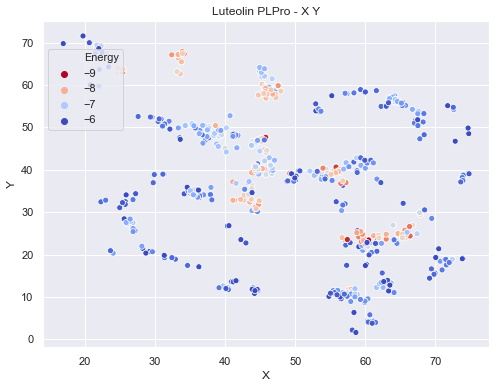

In [19]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='Energy',palette='coolwarm_r')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.65, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y')
#para salvar a figura
#figure.savefig('XY'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - X Z')

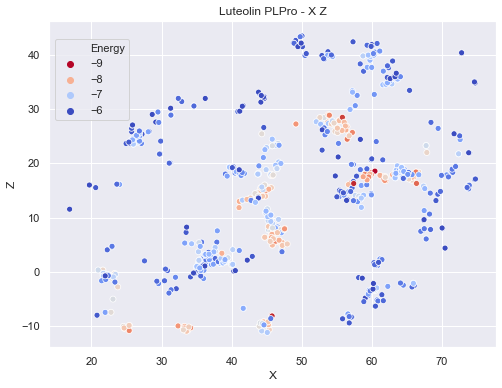

In [20]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='Energy',palette='coolwarm_r')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.68, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z')
#para salvar a figura
#figure.savefig('XZ'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - Y Z')

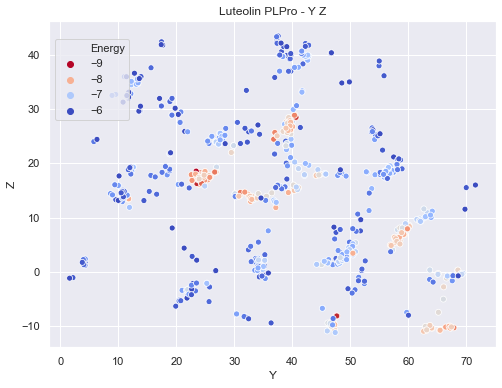

In [21]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='Energy',palette='coolwarm_r')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.68, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z')
#para salvar a figura
#figure.savefig('YZ'+'.png', dpi=600)

__CLUSTERIZAÇÃO__

Daqui para frente iremos trabalhar com a clusterização dos dados coletados. Fique a vontade para modificar os parâmetros dos algoritmos de clusterização da forma que achar melhor.

__Começamos com o KMeans__

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [23]:
km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(df)
df['cluster'] = y_predicted

Vizualização do nosso DataFrame com a coluna "cluster"

In [24]:
df.head()

,x,y,z,RMSD,Energy,cluster
441,26.653833,26.830191,23.974912,34.657069,-7.0,1
442,23.959025,20.494271,16.146805,37.145818,-6.5,1
443,23.621971,20.904739,16.182165,37.289386,-6.2,1
450,26.688629,26.922118,23.985014,34.636710,-7.1,1
451,25.973763,27.340258,23.586481,35.278902,-7.0,1


Gráficos de dispersão clusterizados.

Text(0.5, 1.0, 'Luteolin PLPro - X Y_CLUSTER')

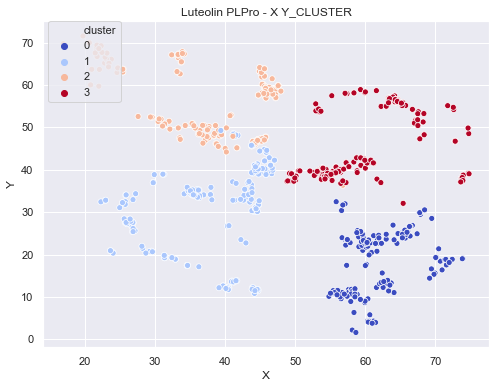

In [25]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y_CLUSTER')
#para salvar a figura
#figure.savefig('XY_CLUSTER'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - X Z_CLUSTER')

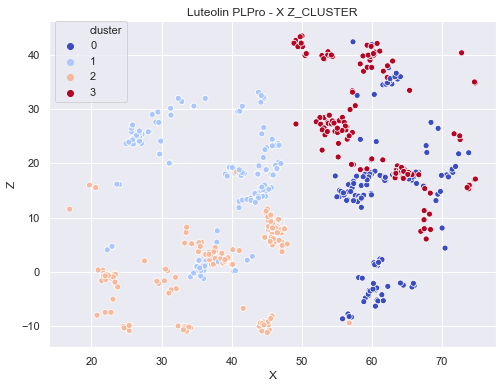

In [26]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z_CLUSTER')
#para salvar a figura
#figure.savefig('XZ_CLUSTER'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - Y Z_CLUSTER')

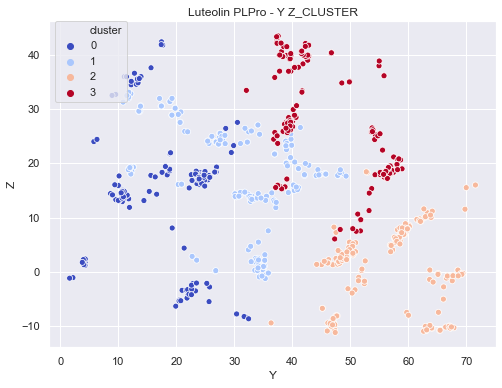

In [27]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z_CLUSTER')
#para salvar a figura
#figure.savefig('YZ_CLUSTER'+'.png', dpi=600)

__Vamos tentar usar o DBSCAN__

In [28]:
from sklearn.cluster import DBSCAN

In [29]:
df = df.drop('cluster', axis = 1)
df.head()

,x,y,z,RMSD,Energy
441,26.653833,26.830191,23.974912,34.657069,-7.0
442,23.959025,20.494271,16.146805,37.145818,-6.5
443,23.621971,20.904739,16.182165,37.289386,-6.2
450,26.688629,26.922118,23.985014,34.636710,-7.1
451,25.973763,27.340258,23.586481,35.278902,-7.0


In [30]:
clustering = DBSCAN(eps= 4, min_samples = 5).fit(df)
cluster = clustering.labels_
outliers_df = pd.DataFrame(df)

In [31]:
df['cluster']=cluster
df.head()

,x,y,z,RMSD,Energy,cluster
441,26.653833,26.830191,23.974912,34.657069,-7.0,0
442,23.959025,20.494271,16.146805,37.145818,-6.5,-1
443,23.621971,20.904739,16.182165,37.289386,-6.2,-1
450,26.688629,26.922118,23.985014,34.636710,-7.1,0
451,25.973763,27.340258,23.586481,35.278902,-7.0,0


Gráficos de dispersão clusterizados com o DBS.

Text(0.5, 1.0, 'Luteolin PLPro - X Y_CLUSTER_DBSCAN')

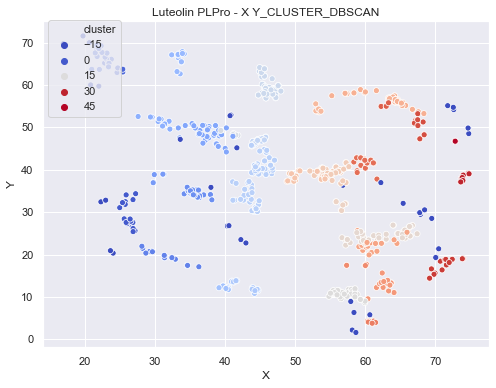

In [32]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.69, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y_CLUSTER_DBSCAN')
#para salvar a figura
#figure.savefig('XY_CLUSTER_DBSCAN'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - X Z_CLUSTER_DBSCAN')

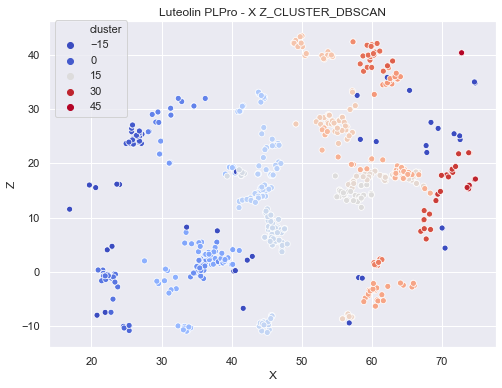

In [33]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.69, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z_CLUSTER_DBSCAN')
#para salvar a figura
#figure.savefig('XZ_CLUSTER_DBSCAN'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - Y Z_CLUSTER_DBSCAN')

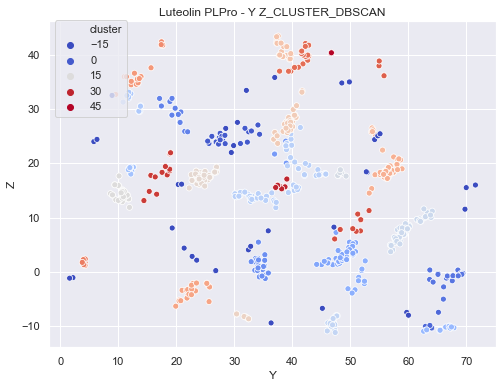

In [34]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.69, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z_CLUSTER_DBSCAN')
#para salvar a figura
#figure.savefig('YZ_CLUSTER_DBSCAN'+'.png', dpi=600)

__Análise com os dados normalizados__

Agora iremos normalizar os nossos dados, isso significar que todos eles estão na mesma escala [0, 1]. Agora todos tem o mesmo peso na hora de calcular o cluster.

In [35]:
scaler = MinMaxScaler()

scaler.fit(df[['x']])
df['x'] = scaler.transform(df[['x']])

scaler.fit(df[['y']])
df['y'] = scaler.transform(df[['y']])

scaler.fit(df[['z']])
df['z'] = scaler.transform(df[['z']])

scaler.fit(df[['RMSD']])
df['RMSD'] = scaler.transform(df[['RMSD']])

scaler.fit(df[['Energy']])
df['Energy'] = scaler.transform(df[['Energy']])

In [36]:
df = df.drop('cluster', axis=1)
df.head()

,x,y,z,RMSD,Energy
441,0.168673,0.360578,0.643268,0.538822,0.655172
442,0.122157,0.269999,0.499967,0.577515,0.827586
443,0.116338,0.275867,0.500615,0.579747,0.931034
450,0.169274,0.361892,0.643453,0.538505,0.620690
451,0.156934,0.367869,0.636157,0.548490,0.655172


A vizualização do gráfico de histograma melhora substancialmente.

In [37]:
pio.renderers.default = 'browser'
fig=go.Figure()

for i, col in enumerate(df.columns):
    a0=np.histogram(df[col], bins=10, density=False)[0].tolist()
    a0=np.repeat(a0,2).tolist()
    a0.insert(0,0)
    a0.pop()
    a1=np.histogram(df[col], bins=10, density=False)[1].tolist()
    a1=np.repeat(a1,2)
    fig.add_traces(go.Scatter3d(x=[i]*len(a0), y=a1, z=a0,
                                mode='lines',
                                name=col))
fig.show()

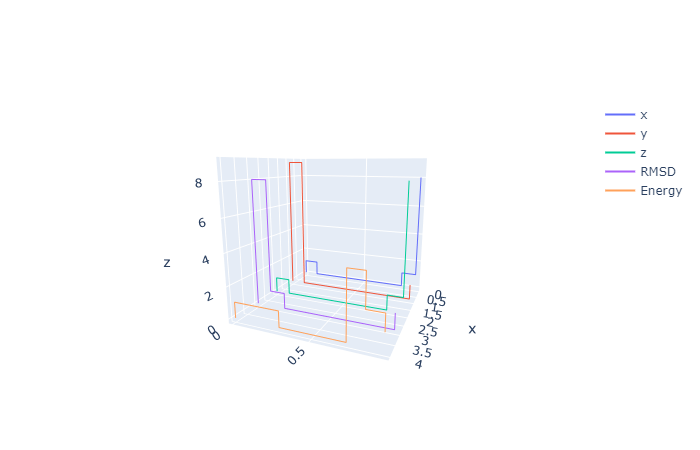

Voltamos com o KMeans.

In [38]:
km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(df)

In [39]:
df['cluster']=y_predicted
df.head()

,x,y,z,RMSD,Energy,cluster
441,0.168673,0.360578,0.643268,0.538822,0.655172,3
442,0.122157,0.269999,0.499967,0.577515,0.827586,3
443,0.116338,0.275867,0.500615,0.579747,0.931034,3
450,0.169274,0.361892,0.643453,0.538505,0.620690,3
451,0.156934,0.367869,0.636157,0.548490,0.655172,3


Os gráficos ficam.

Text(0.5, 1.0, 'Luteolin PLPro - X Y_CLUSTER_KMEANS_NORMAL')

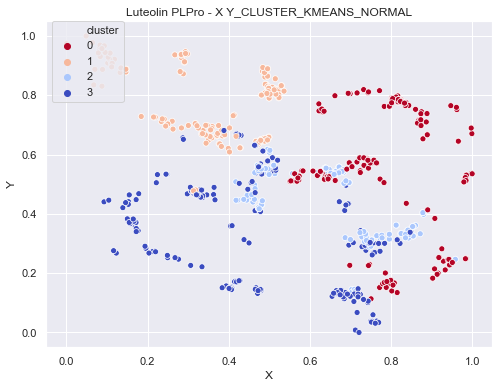

In [40]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='cluster',palette='coolwarm_r')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y_CLUSTER_KMEANS_NORMAL')
#figure.savefig('XY_CLUSTER_NORMAL'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - X Z_CLUSTER_KMEANS_NORMAL')

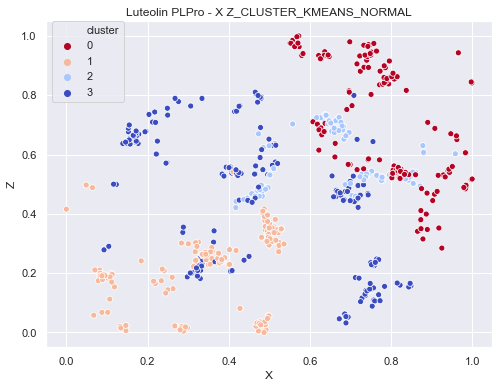

In [41]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='cluster',palette='coolwarm_r')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z_CLUSTER_KMEANS_NORMAL')
#figure.savefig('XZ_CLUSTER_NORMAL'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - Y Z_CLUSTER_KMEANS_NORMAL')

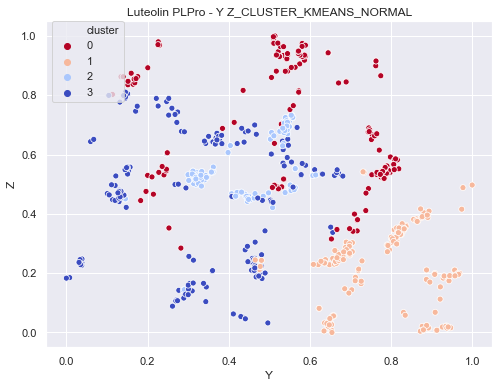

In [42]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='cluster',palette='coolwarm_r')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z_CLUSTER_KMEANS_NORMAL')
#figure.savefig('YZ_CLUSTER_NORMAL'+'.png', dpi=600)

__Elbow Method__

In [43]:
df = df.drop('cluster', axis=1)

In [44]:
sse = []
k_rng = range(1,5)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df)
    sse.append(km.inertia_)

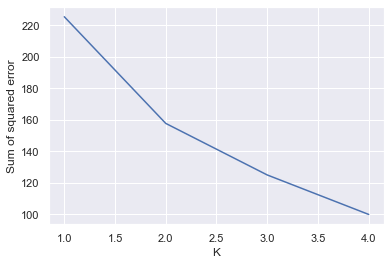

In [45]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [46]:
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(df)

df['cluster']=y_predicted

Agora, voltamos para o DBSCAN normalizado.

In [47]:
df = df.drop('cluster', axis=1)
df.head()

,x,y,z,RMSD,Energy
441,0.168673,0.360578,0.643268,0.538822,0.655172
442,0.122157,0.269999,0.499967,0.577515,0.827586
443,0.116338,0.275867,0.500615,0.579747,0.931034
450,0.169274,0.361892,0.643453,0.538505,0.620690
451,0.156934,0.367869,0.636157,0.548490,0.655172


In [48]:
clustering = DBSCAN(eps= 0.1, min_samples = 5).fit(df)
cluster = clustering.labels_
outliers_df = pd.DataFrame(df)

In [49]:
df['cluster']=cluster

Os gráficos ficam.

Text(0.5, 1.0, 'Luteolin PLPro - X Y_CLUSTER_NORMAL_DBSCAN')

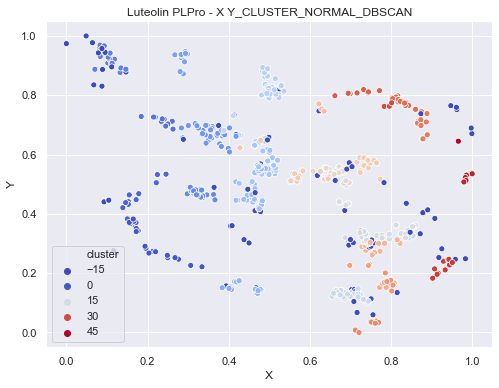

In [50]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y_CLUSTER_NORMAL_DBSCAN')
#figure.savefig('XY_CLUSTER_NORMAL_DBSCAN'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - X Z_CLUSTER_NORMAL_DBSCAN')

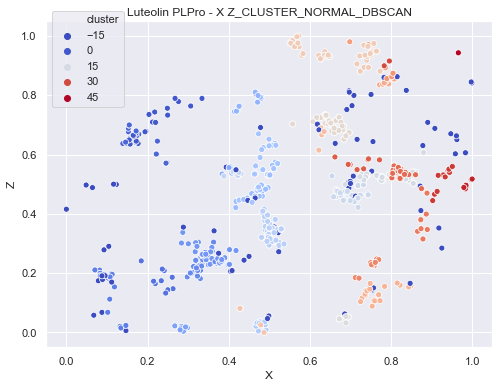

In [51]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.72, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z_CLUSTER_NORMAL_DBSCAN')
#figure.savefig('XZ_CLUSTER_NORMAL_DBSCAN'+'.png', dpi=600)

Text(0.5, 1.0, 'Luteolin PLPro - Y Z_CLUSTER_NORMAL_DBSCAN')

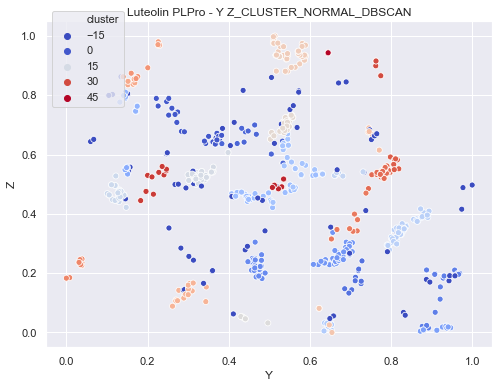

In [52]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.72, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z_CLUSTER_NORMAL_DBSCAN')
#figure.savefig('YZ_CLUSTER_NORMAL_DBSCAN'+'.png', dpi=600)

In [ ]:
log,50,43,-5, -8.7